# Análisis reproducible — Predicción de `total_alquileres` por hora

Este cuaderno está organizado en bloques claros: 1) carga e inspección, 2) limpieza exhaustiva, 3) EDA visual, 4) modelado rápido, 5) diagnóstico y guardado de artefactos.

## Resumen de pasos
- Cargar datos y detectar columna `fecha` si existe.
- Limpiar y normalizar datos (duplicados, nulos, tipos, outliers).
- Explorar: matriz de correlación, distribuciones y serie temporal.
- Entrenar un modelo baseline (RandomForest).
- Diagnosticar con gráficos y una matriz de confusión por bins.

In [1]:
# Bloque 1: imports y configuración
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import joblib
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

## Bloque 2: carga de datos y chequeos iniciales

In [2]:
DATA_PATH = Path('dataset_alquiler.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'No se encuentra {DATA_PATH}. Coloca el CSV en la raíz del repo.')
df = pd.read_csv(DATA_PATH, low_memory=False)
print('Dimensiones originales:', df.shape)
display(df.head())
display(df.dtypes)
# Detectar columna fecha y convertir si existe
for col in ['fecha','Fecha','date','timestamp','datetime']:
    if col in df.columns:
        df['fecha'] = pd.to_datetime(df[col], errors='coerce')
        print('Usando columna de fecha:', col)
        break

Dimensiones originales: (17379, 17)


,indice,fecha,temporada,anio,mes,hora,feriado,dia_semana,dia_trabajo,clima,temperatura,sensacion_termica,humedad,velocidad_viento,u_casuales,u_registrados,total_alquileres
0,1,2011-01-01,1,0,1,0.0,0,6.0,0,1,0.24,0.2879,0.81,0.0,3,13,16.0
1,2,2011-01-01,1,0,1,1.0,0,6.0,0,1,0.22,0.2727,0.80,0.0,8,32,40.0
2,3,2011-01-01,1,0,1,2.0,0,6.0,0,1,0.22,0.2727,0.80,0.0,5,27,32.0
3,4,2011-01-01,1,0,1,3.0,0,6.0,0,1,0.24,0.2879,0.75,0.0,3,10,13.0
4,5,2011-01-01,1,0,1,4.0,0,NaN,0,1,0.24,0.2879,0.75,0.0,0,1,1.0


indice                 int64
fecha                 object
temporada              int64
anio                   int64
mes                    int64
hora                 float64
feriado                int64
dia_semana           float64
dia_trabajo            int64
clima                  int64
temperatura          float64
sensacion_termica    float64
humedad              float64
velocidad_viento     float64
u_casuales             int64
u_registrados          int64
total_alquileres     float64
dtype: object

Usando columna de fecha: fecha


## Bloque 3: limpieza exhaustiva (explicada)
Normalización de nombres, duplicados, conversión de tipos, imputación, winsorize y creación de features temporales.

In [3]:
df_clean = df.copy()
# Normalizar nombres
df_clean.columns = [c.strip().lower().replace(' ', '_') for c in df_clean.columns]
# Duplicados
n_dup = df_clean.duplicated().sum()
print(f'Duplicados detectados: {n_dup}')
if n_dup>0:
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
# Conversión tentativa de objetos a numérico cuando corresponda
for c in df_clean.select_dtypes(include=['object']).columns:
    try:
        df_clean[c] = pd.to_numeric(df_clean[c].str.replace(',','.'), errors='ignore')
    except Exception:
        pass
# Fecha
if 'fecha' in df_clean.columns:
    df_clean['fecha'] = pd.to_datetime(df_clean['fecha'], errors='coerce')
# Imputación: num -> mediana; cat -> 'missing'
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols and c!='fecha']
for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median(skipna=True))
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna('missing')
# Outliers simple: winsorize 1%-99% (si scipy está disponible)
try:
    from scipy.stats import mstats
    for c in num_cols:
        try:
            df_clean[c] = mstats.winsorize(df_clean[c], limits=[0.01, 0.01])
        except Exception:
            pass
except Exception:
    pass
# Features temporales
if 'fecha' in df_clean.columns:
    df_clean['hour'] = df_clean['fecha'].dt.hour
    df_clean['dayofweek'] = df_clean['fecha'].dt.dayofweek
    df_clean['month'] = df_clean['fecha'].dt.month
print('Post-limpieza shape:', df_clean.shape)
display(df_clean.head())

Duplicados detectados: 0
Post-limpieza shape: (17379, 20)


,indice,fecha,temporada,anio,mes,hora,feriado,dia_semana,dia_trabajo,clima,temperatura,sensacion_termica,humedad,velocidad_viento,u_casuales,u_registrados,total_alquileres,hour,dayofweek,month
0,174,2011-01-01,1,0,1,0.0,0,6.0,0,1,0.24,0.2879,0.81,0.0,3,13,16.0,0,5,1
1,174,2011-01-01,1,0,1,1.0,0,6.0,0,1,0.22,0.2727,0.80,0.0,8,32,40.0,0,5,1
2,174,2011-01-01,1,0,1,2.0,0,6.0,0,1,0.22,0.2727,0.80,0.0,5,27,32.0,0,5,1
3,174,2011-01-01,1,0,1,3.0,0,6.0,0,1,0.24,0.2879,0.75,0.0,3,10,13.0,0,5,1
4,174,2011-01-01,1,0,1,4.0,0,3.0,0,1,0.24,0.2879,0.75,0.0,0,1,2.0,0,5,1


## Bloque 4: EDA visual — correlación, distribución y series temporales

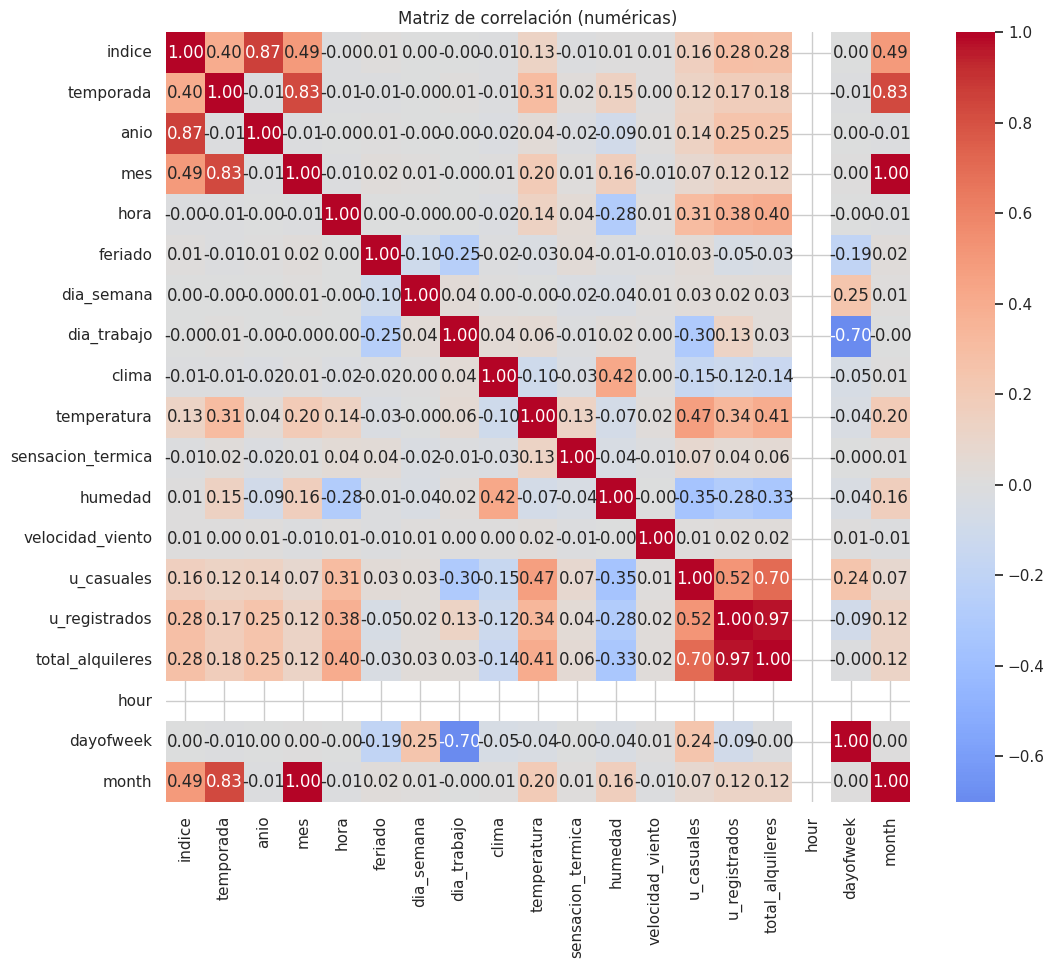

In [4]:
# Matriz de correlación (numéricas)
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df_clean[num_cols].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Matriz de correlación (numéricas)')
    plt.show()
else:
    print('No hay suficientes variables numéricas para una matriz de correlación clara.')

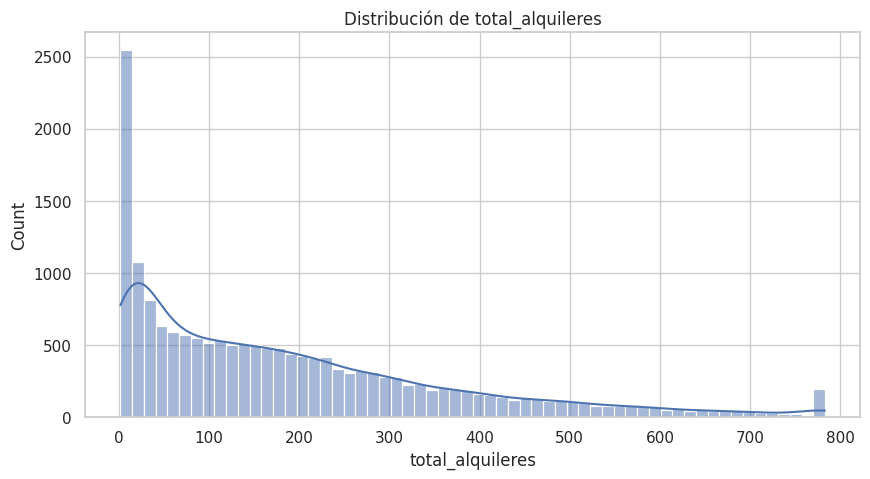

count    17379.000000
mean       188.905806
std        179.122375
min          2.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        783.000000
Name: total_alquileres, dtype: float64

In [5]:
# Distribución del objetivo y estadísticos
target = 'total_alquileres' if 'total_alquileres' in df_clean.columns else (num_cols[-1] if num_cols else None)
if target is not None:
    plt.figure()
    sns.histplot(df_clean[target], kde=True, bins=60)
    plt.title(f'Distribución de {target}')
    plt.show()
    display(df_clean[target].describe())
else:
    print('Objetivo no detectado; especifica `total_alquileres`.')

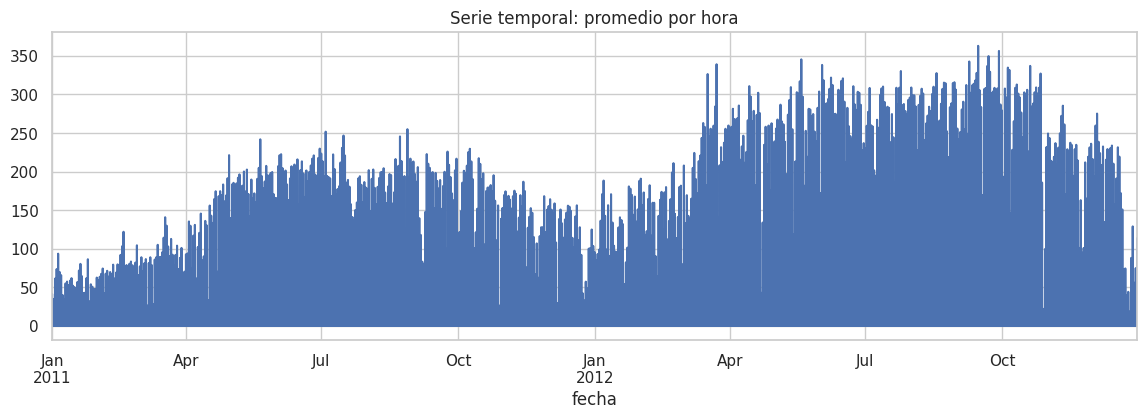

In [6]:
# Serie temporal promedio por hora (si existe fecha)
if 'fecha' in df_clean.columns and target in df_clean.columns:
    ts = df_clean.set_index('fecha').resample('H')[target].mean().fillna(0)
    plt.figure(figsize=(14,4))
    ts.plot()
    plt.title('Serie temporal: promedio por hora')
    plt.show()
else:
    print('No es posible generar serie temporal (falta fecha o objetivo)')

## Bloque 5: modelado rápido (baseline) y métricas

In [7]:
# Preparar X,y y entrenar RandomForest baseline
features = [c for c in df_clean.columns if c != target and c != 'fecha']
X = df_clean[features].select_dtypes(include=[np.number]).fillna(0)
y = df_clean[target].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('MAE:', mean_absolute_error(y_test, pred))
print('R2 :', r2_score(y_test, pred))

RMSE: 4.49399287388374
MAE: 1.2379027617951666
R2 : 0.9993461103463672


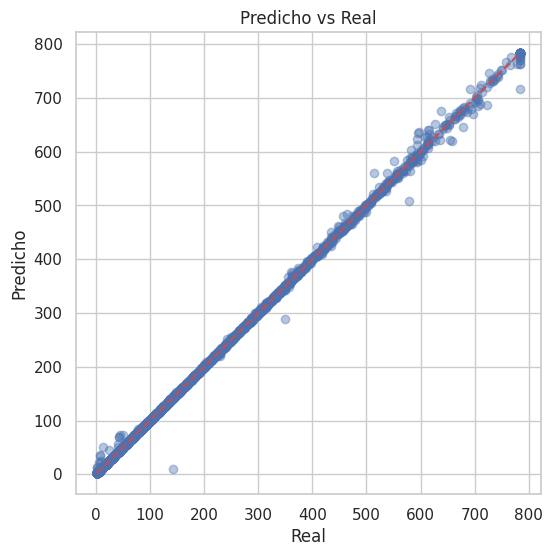

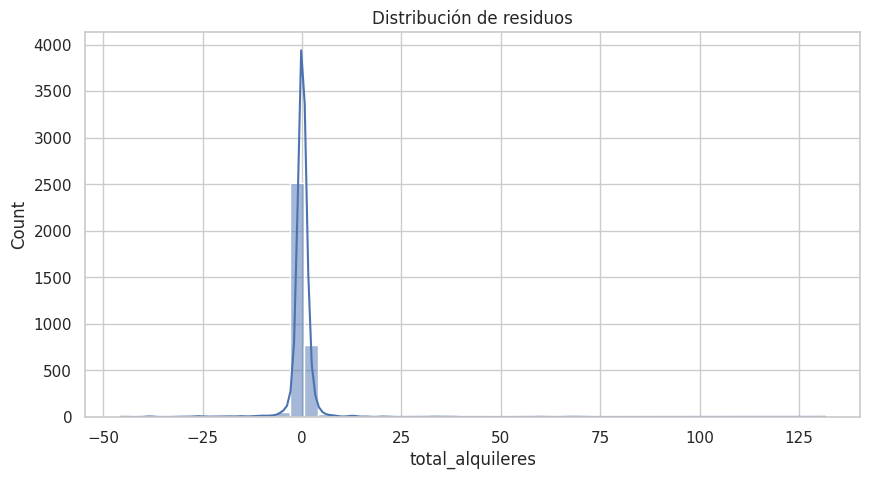

In [8]:
# Diagnóstico visual: Pred vs Real y residuos
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicho vs Real')
plt.show()
res = y_test - pred
plt.figure()
sns.histplot(res, kde=True, bins=50)
plt.title('Distribución de residuos')
plt.show()

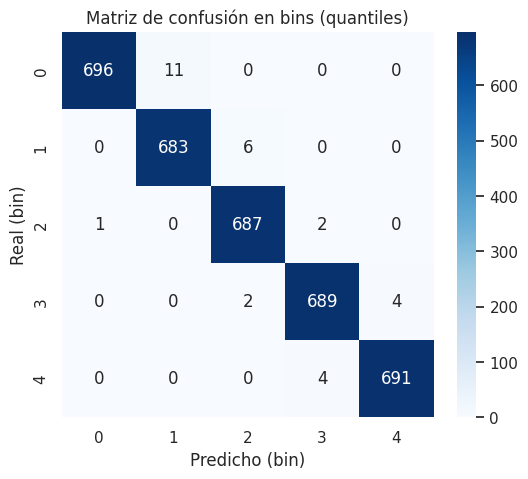

In [9]:
# Matriz de confusión por bins (diagnóstica)
try:
    n_bins = 5
    bins = pd.qcut(y_test, q=n_bins, labels=False, duplicates='drop')
    pred_bins = pd.qcut(pd.Series(pred), q=n_bins, labels=False, duplicates='drop')
    cm = confusion_matrix(bins, pred_bins)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho (bin)')
    plt.ylabel('Real (bin)')
    plt.title('Matriz de confusión en bins (quantiles)')
    plt.show()
except Exception as e:
    print('No fue posible calcular matriz de confusión por bins:', e)

u_registrados        9.493343e-01
u_casuales           5.002205e-02
indice               1.265448e-04
humedad              1.080430e-04
temperatura          6.609893e-05
velocidad_viento     6.403251e-05
dayofweek            5.985309e-05
sensacion_termica    4.972548e-05
hora                 4.952780e-05
dia_semana           2.463467e-05
month                2.313446e-05
mes                  2.004392e-05
dia_trabajo          1.828961e-05
temporada            1.145062e-05
clima                1.104690e-05
anio                 1.038228e-05
feriado              8.470000e-07
hour                 0.000000e+00
dtype: float64

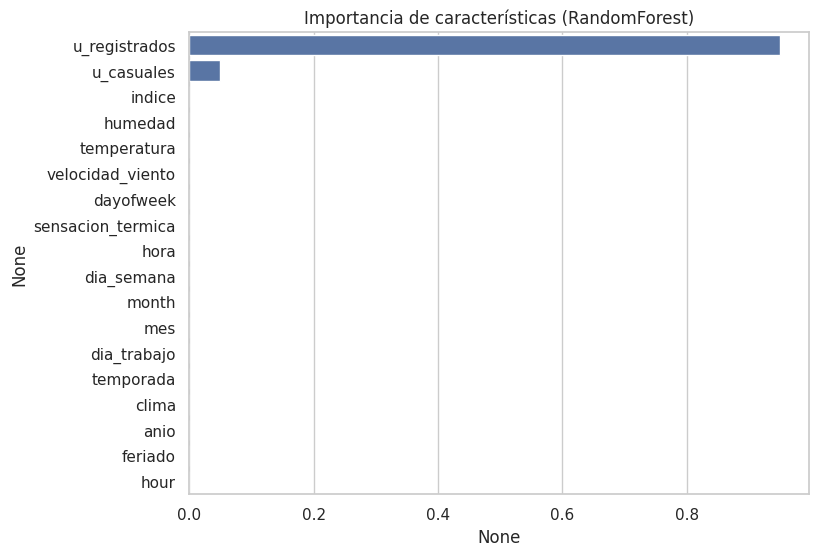

SHAP no disponible o falló: No module named 'shap'


In [10]:
# Importancia de features y SHAP (opcional)
try:
    imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(imp.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x=imp.head(20), y=imp.head(20).index)
    plt.title('Importancia de características (RandomForest)')
    plt.show()
except Exception as e:
    print('No se pudo calcular importancias:', e)
# SHAP (si está instalado)
try:
    import shap
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.show()
except Exception as e:
    print('SHAP no disponible o falló:', e)

In [11]:
# Guardar modelo baseline
out_dir = Path('models')
out_dir.mkdir(exist_ok=True)
joblib.dump(model, out_dir / 'notebook_baseline.joblib')
print('Modelo guardado en models/notebook_baseline.joblib')

Modelo guardado en models/notebook_baseline.joblib
